# End-to-end Creation of a Flat Value Predictor

In [29]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm import tqdm

pd.set_option('display.max_columns', None)

## 0. Reading

Firstly, we read the files generated previously through web scraping.

In [30]:
df_p1 = pd.read_csv("data/data1.csv")
df_p2 = pd.read_csv("data/data2.csv")
df_p3 = pd.read_csv("data/data70_140.csv")
df_p4 = pd.read_csv("data/data140_210.csv")
df_p5 = pd.read_csv("data/data210_310.csv")
df_p6 = pd.read_csv("data/data310_410.csv")
df_p7 = pd.read_csv("data/data410_500.csv")
df_p8 = pd.read_csv("data/data500_510.csv")

df = pd.concat([df_p1, df_p2, df_p3, df_p4, df_p5, df_p6, df_p7, df_p8]).drop_duplicates()

## 1. Data Cleaning and Preprocessing

The first stage of a Data Science/Data Analysis project is **Data Cleaning and Preprocessing**. This comes after **Problem Definition and Understanding**, as well as **Data Collection**, which we have already completed.

We have decided that **if a categorical attribute has both descriptive and numerical features, we will prioritize the descriptive one**, as we have found it to be more reliable after thorough examination. This decision may require additional processing in the future, such as transformations or encodings.

Therefore, we are dropping columns either because we chose to prioritize descriptive attributes or because we deemed them irrelevant after examining the exploratry data analysis.

In [31]:
print("Initial dataframe shape:", df.shape)

Initial dataframe shape: (9684, 114)


In [32]:
# Rename columns to a better clarity
df = df.rename(columns={"orientation.1":"orientation_desc", "floor.1":"floor_desc", "antiquity.1":"antiquity_desc", "conservationState.1":"conservationState_desc", "hotWater.1":"hotWater_type_desc", "heating.1":"heating_desc"})

# Filtering to have reasonable data
df = df[(df["value"]>0) & (df["surface"]>0) & (df["surface"].notna()) & (df["surface"] < 1000) & (df["energy_value"]<999) & (df["environment_value"]<999) & (df["value"].notna())].reset_index(drop=True)

# We drop the following columns because we decided to prevail the descriptive ones, or we decided are irrelevant after looking the EDA
cols_drop = ["type", "subtype", "external_contract", "invalid", "transactions", "transaction_type", "periodicity_id", "energyCertificate", "surfaceLand", "countryId", "level1Id",
             "level2Id", "level3Id", "level4Id", "level5Id", "level6Id", "level7Id", "level8Id",
             "conservationState", "orientation", "hotWater", "heating", "antiquity", "highlight", "Muebles de diseño", "Música ambiental","Sala de cine",
             "id","accuracy"]
try: df = df.drop(columns=cols_drop)
except: print("Some error ocurred. Maybe already dropped columns")


### Column types

Here, we only **check the data types and change them if needed**. For example, because of how we gather and process information during the scraping process, some features may initially be stored as numbers when they should actually be boolean values.

In [33]:
# df.info()

In [34]:
# changing dtypes in some columns
df["date"] = pd.to_datetime(df["date"].str[:10])
multimedia_columns = ["multimedia_type_2","multimedia_type_6","multimedia_type_12","multimedia_type_21","multimedia_type_5"]
df[multimedia_columns] = df[multimedia_columns].fillna(0).astype(int)

# processing boolean features (df.columns[45:87])
bool_features_cols = [
    'furnished','parking', 'Aire acondicionado', 'Parquet', 'Horno', 'Microondas',
    'Serv. portería', 'Balcón', 'Lavadero', 'Armarios', 'Calefacción',
    'Suite - con baño', 'Nevera', 'Puerta Blindada', 'Terraza',
    'Electrodomésticos', 'Alarma', 'Cocina Equipada', 'Lavadora',
    'Cocina Office', 'Patio', 'Videoportero', 'Piscina', 'Gres Cerámica',
    'Jardín Privado', 'Trastero', 'Internet', 'Domótica', 'TV',
    'Ascensor interior', 'Sistema Video vigilancia CCTV 24h',
    'Z. Comunitaria', 'Zona Deportiva', 'Zona Infantil',
    'Piscina comunitaria', 'Gimnasio', 'Baño de huéspedes',
    'Cuarto para el servicio', 'Jacuzzi', 'Bodega', 'Sauna',
    'Cuarto lavado plancha', 'Energía Solar', 'elevator', 'Pista de Tenis', 'Porche cubierto'
] 
for colname in bool_features_cols:
    df[colname] = np.where(df[colname]>0, True, False)

df["energy_letter"] = df["energy_letter"].astype('O')
df["environment_letter"] = df["environment_letter"].astype('O')

### Outliers removal

**Tukey's method** is based on interquartile range (IQR) and is robust to skewed distributions, while the **z-score method** 
relies on mean and standard deviation and is sensitive to extreme values. The choice between these methods depends 
on the nature of our data and the specific requirements of our analysis. It's often a good practice to try both 
methods and compare their effects. \
We decided to keep the **Tukey's method** results.

IQR: 5696 | Actual: 6185 | 92.09%
Z-score: 5922 | Actual: 6185 | 95.75%


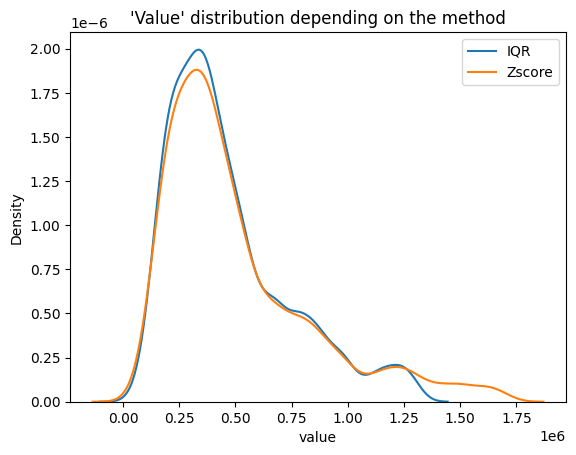

In [35]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliers_zscore(df, column, threshold=2):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores < threshold]

df_iqr = remove_outliers_iqr(df, "value").copy()
df_z = remove_outliers_zscore(df, "value").copy()

print(f"IQR: {len(df_iqr)} | Actual: {len(df)} | {(len(df_iqr)/len(df))*100:.2f}%")
print(f"Z-score: {len(df_z)} | Actual: {len(df)} | {(len(df_z)/len(df))*100:.2f}%")

sns.kdeplot(df_iqr["value"], label="IQR")
sns.kdeplot(df_z["value"], label="Zscore")
plt.legend()
plt.title("'Value' distribution depending on the method")
plt.show()

In [36]:
df = remove_outliers_iqr(df, "value").reset_index(drop=True).copy()

duplicates_columns = ["value", "zipcode", "energy_value", "energy_letter","environment_value", "rooms", "bathrooms", "surface", "floor", "upperLevel"]
df = df.drop_duplicates(subset=duplicates_columns, keep='first')

print("Final dataset shape, after removing outliers and drop duplicates: ", df.shape)

Final dataset shape, after removing outliers and drop duplicates:  (4395, 85)


### Null imputation

In [37]:
def boxplot_frequencies(column, sort_column, data):
    fig, ax1 = plt.subplots(figsize=(12,3))
    df_plot = data[list(set([column, "value",sort_column]))].fillna('NA').sort_values(sort_column)
    ax1.bar(df_plot[column].unique(), df_plot.groupby(sort_column).size(), color='lightgrey')
    ax1.set_ylabel("count")
    ax2 = ax1.twinx()
    sns.boxplot(data=df_plot, x=column, y='value', showfliers=False, showmeans=True, ax=ax2)
    plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
    ax1.tick_params(labelrotation=30)
    plt.legend(loc="upper right")
    plt.title(f"Value distribution by {column}")
    plt.show()

def plot_boxplot_frequencies(columns, sort_columns, data):
    for column, sort_column in zip(columns, sort_columns):
        boxplot_frequencies(column, sort_column, data)
        

After this preprocessing, there are only the following columns that contain missing values. \
The first thing we need to ask ourselves is whether the column with nulls actually provides relevant information. If a column is not relevant, we simply remove it directly, and there's no need for null imputation.

**How do we know if a feature is relevant?** By analyzing the different features during the Exploratory Data Analysis (EDA) phase. That's why **a Data Science project is an iterative or circular process**. Although EDA typically occurs after null imputation and data preprocessing, **we may require EDA to determine which null imputation strategy is needed**.

The same applies to feature engineering. **Depending on how we decide to transform features, nulls may need to be imputed differently**, requiring adjustments to previous stages of the process.

In [38]:
df.isna().sum()[df.isna().sum()>0]

advertiser                   6
description                 20
ubication                  943
orientation_desc          1901
floor_desc                 945
antiquity_desc             935
conservationState_desc    1466
hotWater_type_desc        3040
heating_desc              2985
level6                    4395
level8                      77
dtype: int64

**What we will do with missings:**

- Advertiser, description, and ubication are very specific features, so it doesn't make sense to perform any type of imputation. Therefore, we will drop them.
- We can get rid of **'level6'**, as it is a general feature. **'level8'**, on the other hand, is more important as it is a specific geographical feature and has a strong correlation with the 'value' variable. **We should remove the examples with missing values in the 'level8' column.**
- For the other descriptive features, **we have to decide whether to fill them with "NA" or not**. After assessing their performance on different models, **we decided to keep the missing values. Since we are using a tree-based algorithm, it can handle NaNs, and the performance is better than filling them with 'NA'.**

In [39]:
df_nonull = df.copy()
df_nonull = df_nonull.drop(columns=["level6"])
df_nonull = df_nonull[df_nonull.level8.notna()].reset_index(drop=True)

The **floor_desc feature is the most difficult to impute, as we suppose it is an important factor to decide the value of a flat** (as we can see in the EDA boxplots, it significantly affects the value).\
It is also difficult encode at Feature Engineering part, because it can behave like a descriptive feature with different categories: "sótano", "subsótano", "bajos", and therefore, be encoded with a **one-hot encodong**; or it can behave like numbers in order: "1st floor", "2nd floor", and then encode it with a **ordinal encoding**, as it is quantificable.

After analyzing their performance with different models, **we also decided to keep the missing values**.

## 2. Exploratory Data Analysis

At the **Exploratory Data Analysis (EDA)** part, the objective is to **understand and analyze the data, identify patterns, biases, correlations, and gain insights before proceeding to the modeling part**. It will also help us to perform better feature engineering and feature selection.

In [40]:
df_des = df_nonull.select_dtypes(include = ['O'])
df_num = df_nonull.select_dtypes(include = ['int64','float64'])
df_bool = df_nonull.select_dtypes(include = ['bool'])

### Target Variable: Value

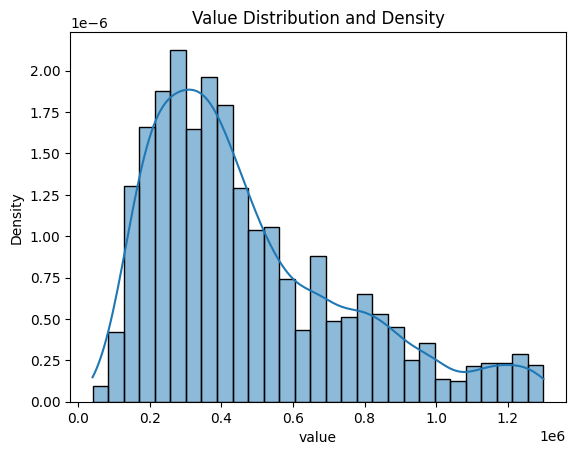

The average price per flat in Barcelona is: 475086€
The median is: 395000€


In [41]:
sns.histplot(df_nonull.value, kde=True, stat="density")
plt.title("Value Distribution and Density")
plt.show()
print(f"The average price per flat in Barcelona is: {np.mean(df_nonull['value']):.0f}€")
print(f"The median is: {np.median(df_nonull['value']):.0f}€")

### Descriptive Variables General Plots

In [42]:
print("Descriptive columns: ", ', '.join(df_des.columns))

Descriptive columns:  advertiser, description, ubication, energy_letter, environment_letter, orientation_desc, floor_desc, antiquity_desc, conservationState_desc, hotWater_type_desc, heating_desc, country, level1, level2, level3, level4, level5, level7, level8, upperLevel


In regression projects, I really like to use **boxplots** to see how the descriptive features affect the target.
- floor_desc: ascending pattern in numerical floors from 1 to 9.
- energy_letter: descending pattern (0 is missing value).
- environment_letter: descending pattern (0 is missing value).
- orientation_desc: orientations that contain south and east are usually more expensive.
- antiquity: logical descending pattern from "5-10" to "50-70"
- hotWater_type_desc and heating_desc: not enough data to extract conclusions
- level7 (district): totally affects the value. level8 (neighborhood) will be the most important feature.

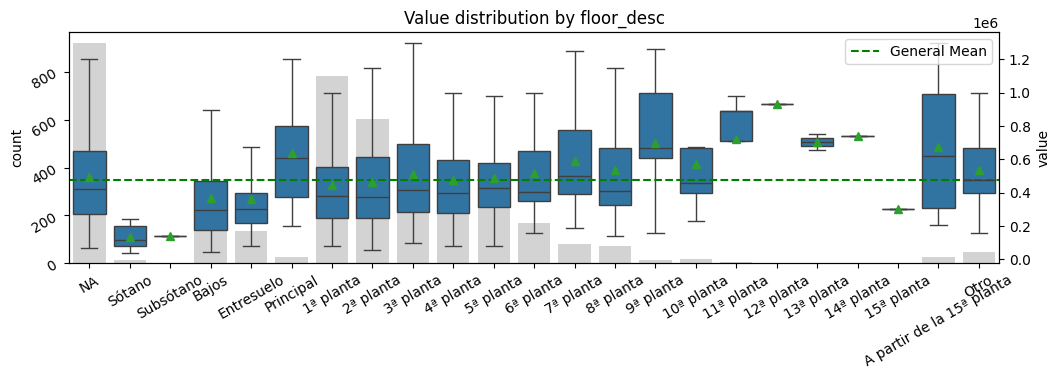

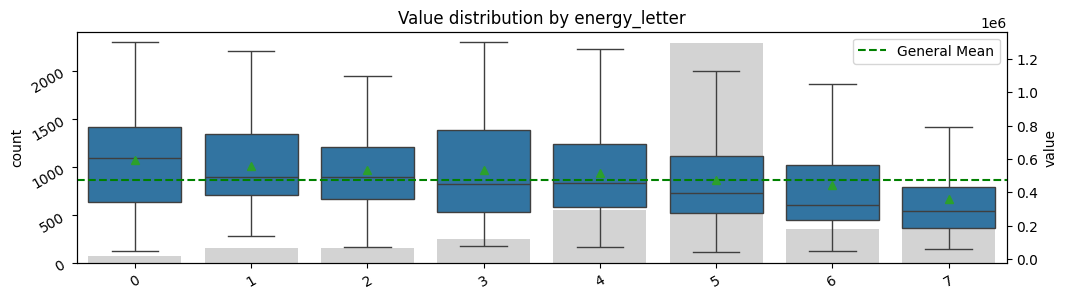

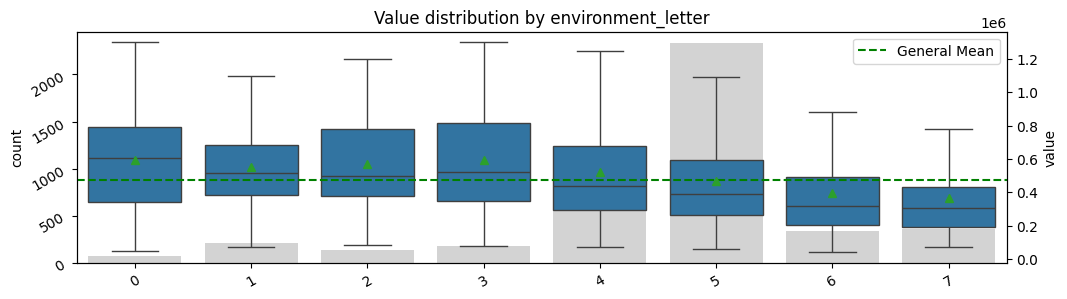

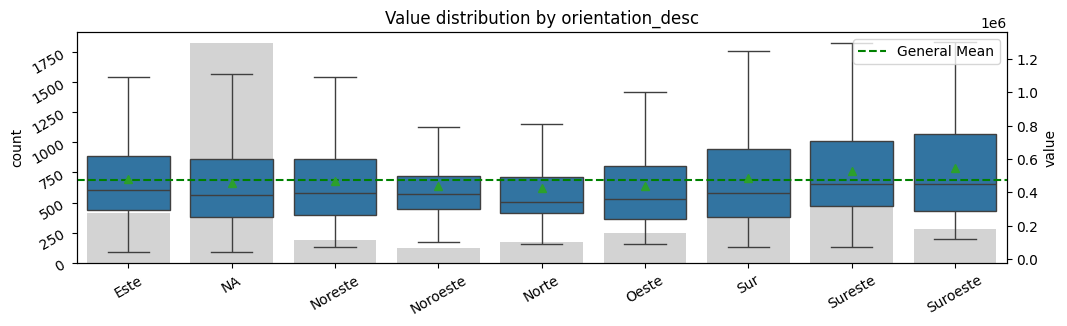

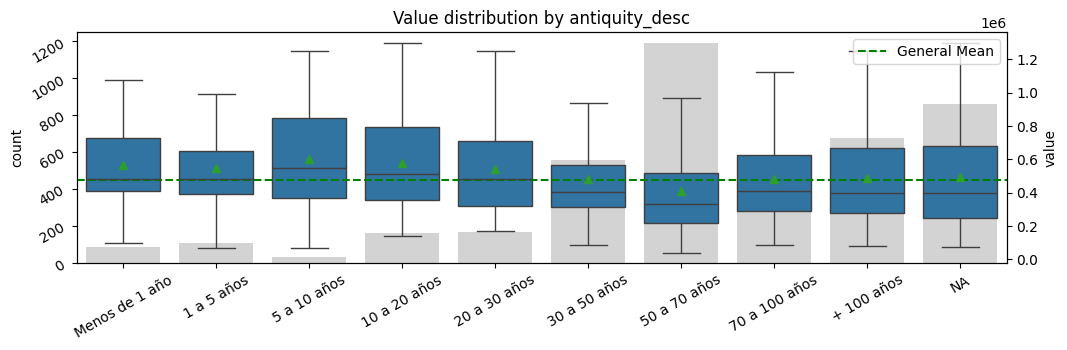

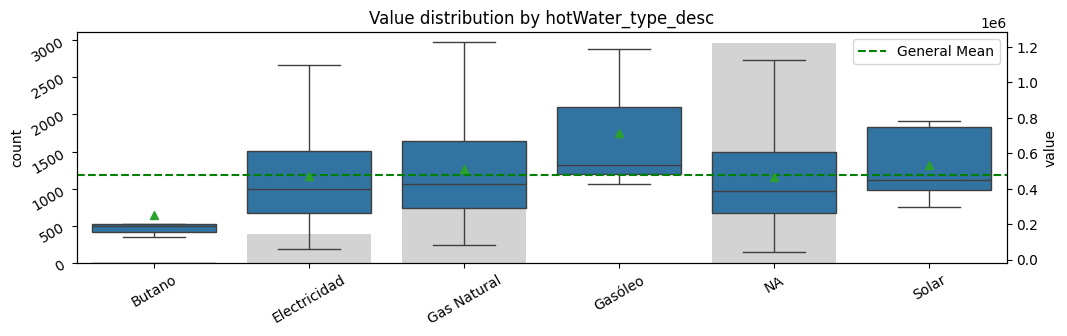

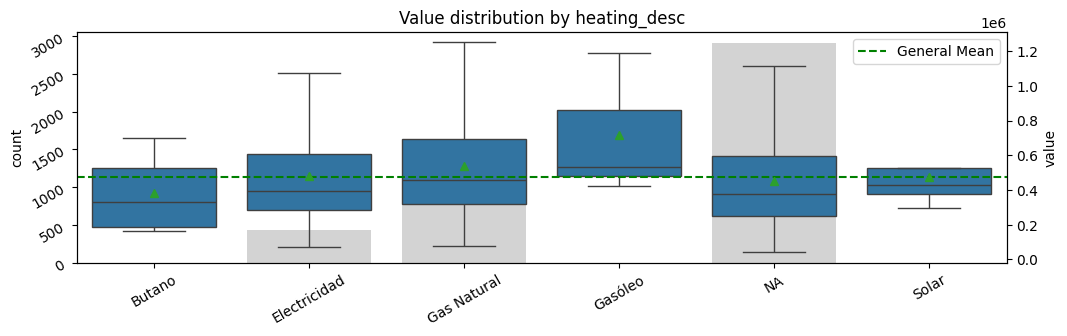

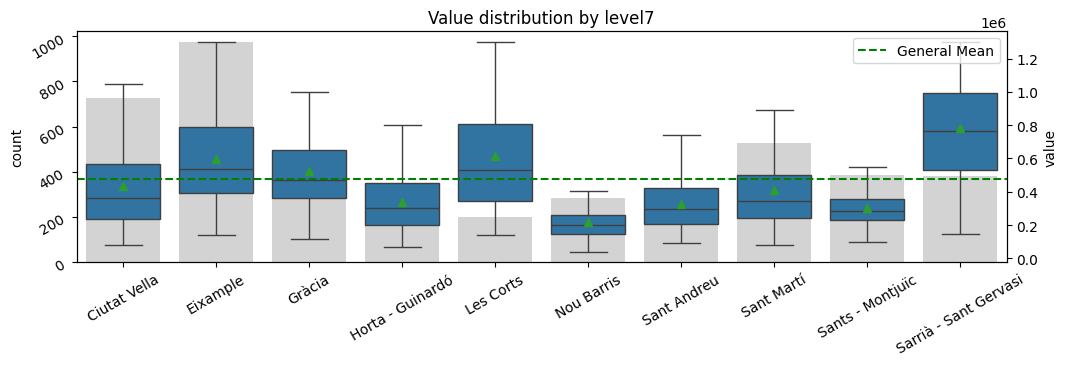

In [43]:
df_nonull["order_antiquity"] = df_nonull["antiquity_desc"].fillna("NA").replace({"1 a 5 años":1,"5 a 10 años":2,"10 a 20 años":3,
                                                                   "20 a 30 años":4,"30 a 50 años":5,"50 a 70 años":6,
                                                                   "70 a 100 años":7,"Menos de 1 año":0,"1 a 5 años":1,
                                                                                 "+ 100 años":8, "NA":50})

des_plot_features = ['floor_desc','energy_letter','environment_letter','orientation_desc','antiquity_desc','hotWater_type_desc','heating_desc','level7']
des_plot_order = ['floor','energy_letter','environment_letter','orientation_desc','order_antiquity','hotWater_type_desc','heating_desc','level7']
plot_boxplot_frequencies(des_plot_features, des_plot_order, df_nonull)


### Boolean Variables General Plots

In [44]:
print("Boolean columns: ", ', '.join(df_bool.columns),"| length:", len(df_bool.columns))


Boolean columns:  new, elevator, furnished, parking, Aire acondicionado, Parquet, Horno, Microondas, Serv. portería, Balcón, Lavadero, Armarios, Calefacción, Suite - con baño, Nevera, Puerta Blindada, Terraza, Electrodomésticos, Alarma, Cocina Equipada, Lavadora, Cocina Office, Patio, Videoportero, Piscina, Gres Cerámica, Jardín Privado, Trastero, Internet, Domótica, TV, Ascensor interior, Sistema Video vigilancia CCTV 24h, Z. Comunitaria, Zona Deportiva, Zona Infantil, Piscina comunitaria, Gimnasio, Baño de huéspedes, Cuarto para el servicio, Jacuzzi, Bodega, Sauna, Cuarto lavado plancha, Energía Solar, Pista de Tenis, Porche cubierto | length: 47


There are too many boxplots to view, but **we can easily observe which variables are worth using in the modeling part** (depending on how they affect the target and if we have the examples correctly distributed).

For example:
"elevator","parking","Aire acondicionado","Parquet","Serv. portería","Balcón","Armarios","Calefacción","Suite - con baño","Terraza","Alarma","Cocina Equipada","Piscina","Trastero","Gres Cerámica","Jardín Privado".

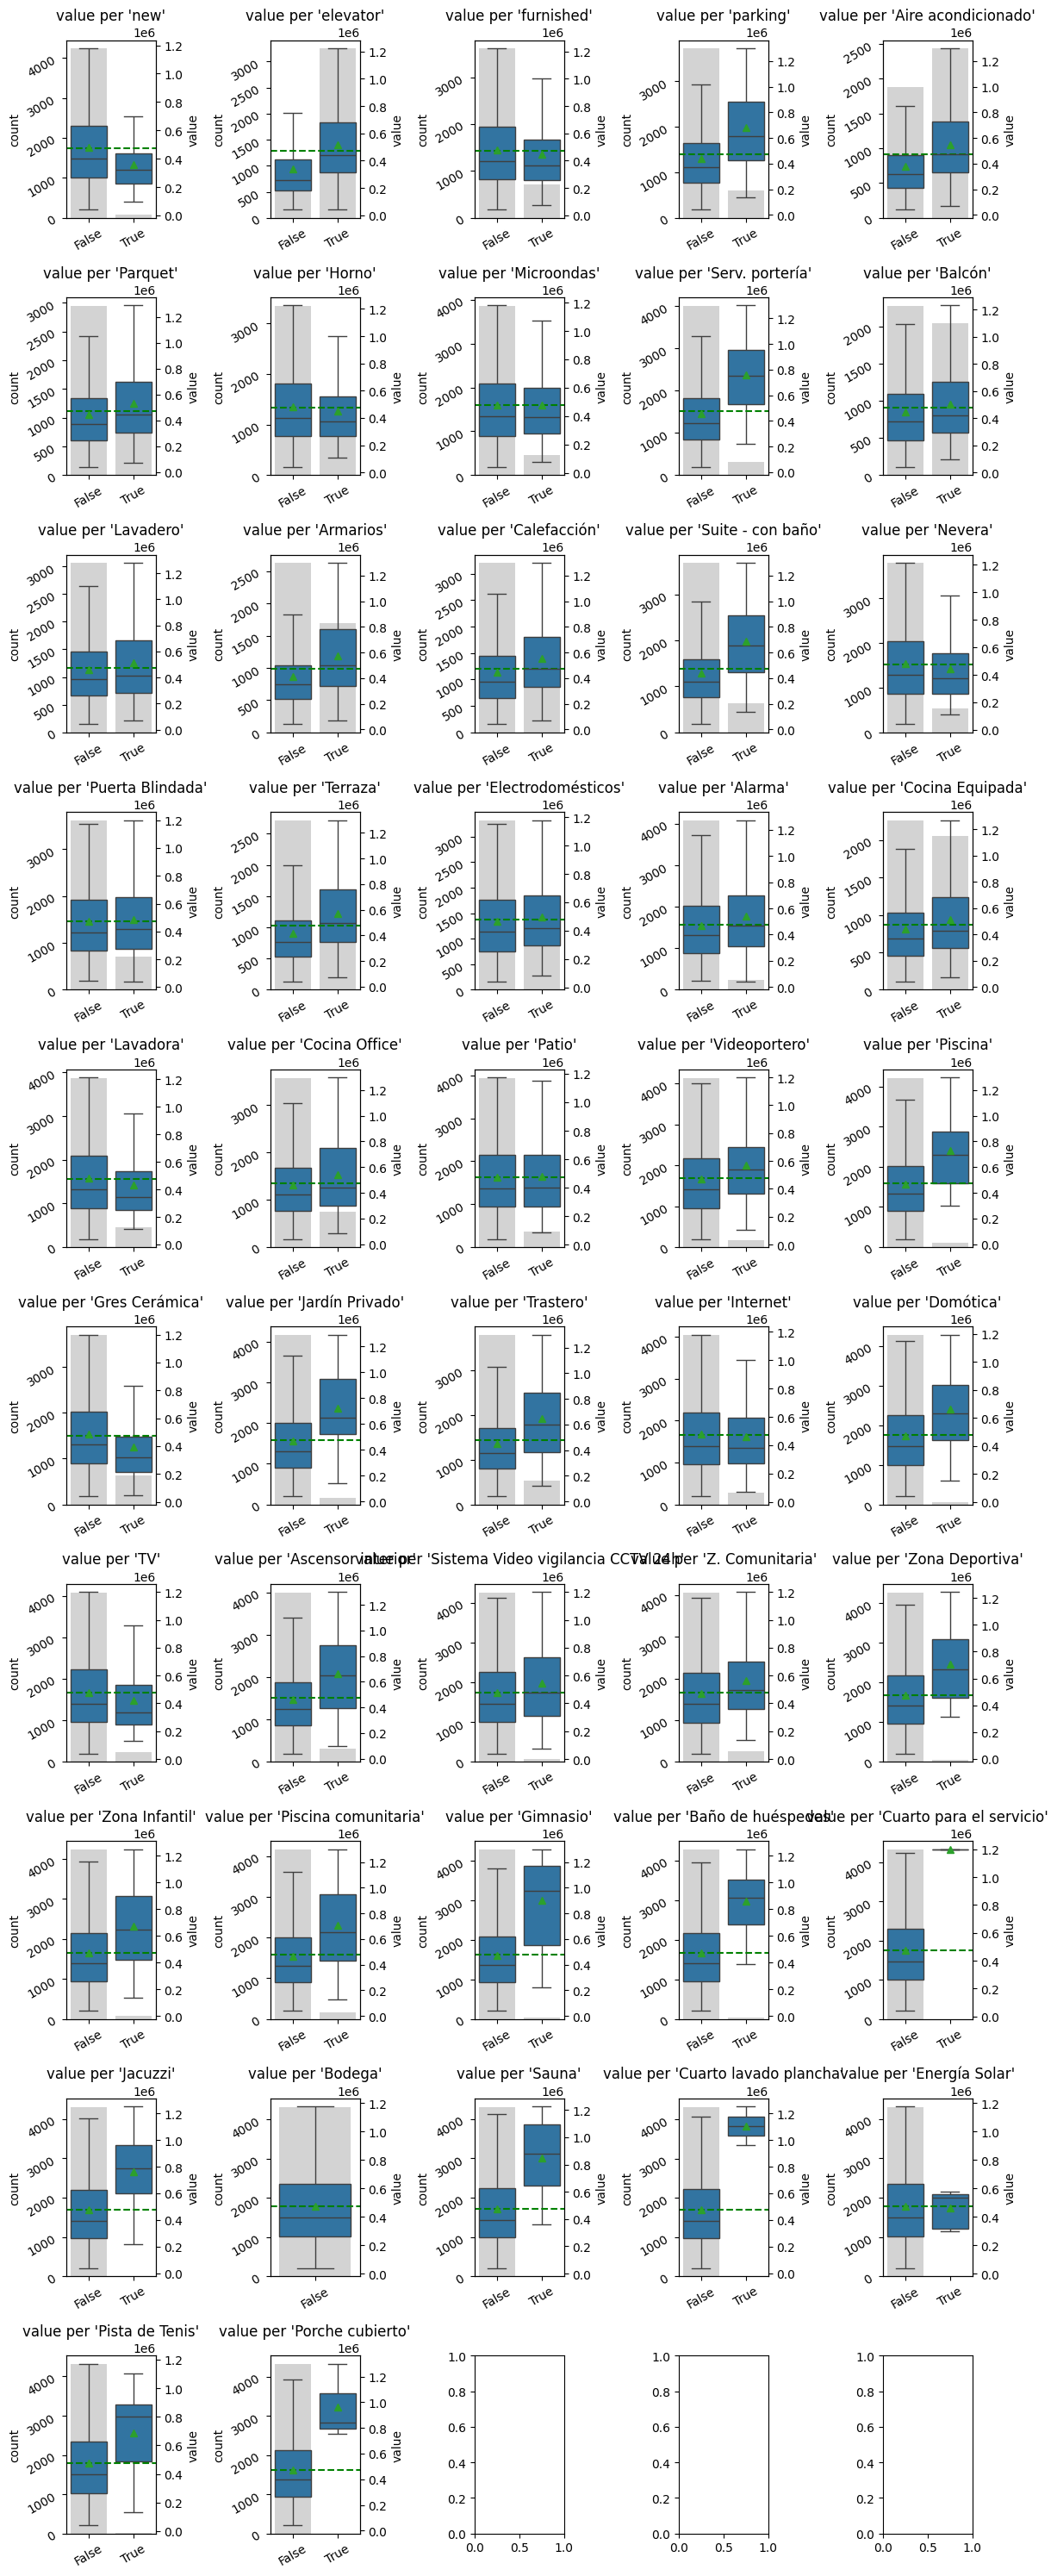

In [45]:
def plot_boxplot_frequencies_subplots(columns, sort_columns, data, nrows, ncols):
    fig, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,nrows*3))
    ax1 = ax1.flatten()
    i=0
    for column, sort_column in zip(columns, sort_columns):
        df_plot = data[list(set([column, "value",sort_column]))].fillna('NA').sort_values(sort_column)
        ax1[i].bar(df_plot[column].unique(), df_plot.groupby(sort_column).size(), color='lightgrey')
        ax1[i].set_ylabel("count")
        ax2 = ax1[i].twinx()
        sns.boxplot(data=df_plot, x=column, y='value', showfliers=False, showmeans=True, ax=ax2)
        plt.axhline(y=df_plot['value'].mean(), color='g', linestyle='--', label='General Mean')
        ax1[i].tick_params(labelrotation=30)
        plt.title(f"value per '{column}'")
        i+=1    
    fig.tight_layout()
    plt.show()

plot_boxplot_frequencies_subplots(df_bool.columns, df_bool.columns, df_nonull, 10, 5)

### Numerical Variables General Plots

This time, I have followed these steps:
1. **Describe** the variables to see basic statistical factors.
2. Use a **correlation matrix** to identify variables that are **highly correlated with the target** value, and **try to avoid using highly correlated ones**.
3. Use **histograms to visualize the distribution of data**. Clear and effective.
4. **Combine scatterplots and boxplots** for further analysis.

In [46]:
print("Numerical columns: ", ', '.join(df_num.columns))
df_nonull = df_nonull.drop(columns=["latitude", "longitude", "zipcode"])


Numerical columns:  value, reduced, zipcode, energy_value, environment_value, multimedia_type_2, multimedia_type_6, multimedia_type_12, multimedia_type_21, multimedia_type_5, rooms, bathrooms, surface, floor, latitude, longitude


In [47]:
df_num = df_nonull.select_dtypes(include = ['int64','float64'])
df_num.describe()

,value,reduced,energy_value,environment_value,multimedia_type_2,multimedia_type_6,multimedia_type_12,multimedia_type_21,multimedia_type_5,rooms,bathrooms,surface,floor,order_antiquity
count,4.318000e+03,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000,4318.000000
mean,4.750861e+05,12220.607689,150.850035,44.787390,27.644048,0.148912,0.122510,0.201019,0.022696,2.851088,1.610699,99.559750,6.216999,14.576887
std,2.798971e+05,33257.410667,88.502099,51.437326,12.148242,0.411568,0.333516,0.474876,0.177346,1.093630,0.730326,46.193398,4.673983,17.720333
min,3.990000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,2.650000e+05,0.000000,100.000000,23.000000,19.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,69.000000,3.000000,5.000000
50%,3.950000e+05,0.000000,145.000000,34.250000,26.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,88.000000,7.000000,6.000000
75%,6.300000e+05,10000.000000,192.000000,49.000000,34.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,119.000000,9.000000,8.000000
max,1.300000e+06,425000.000000,960.000000,978.000000,107.000000,4.000000,2.000000,3.000000,4.000000,8.000000,10.000000,515.000000,31.000000,50.000000


In [48]:
corr = df_num.corr()
corr.style.background_gradient(cmap='coolwarm')

,value,reduced,energy_value,environment_value,multimedia_type_2,multimedia_type_6,multimedia_type_12,multimedia_type_21,multimedia_type_5,rooms,bathrooms,surface,floor,order_antiquity
value,1.000000,0.252285,-0.176486,-0.144000,0.436726,-0.035714,0.042199,0.128340,0.044306,0.392489,0.669318,0.771956,0.072199,0.019887
reduced,0.252285,1.000000,-0.002413,-0.014331,0.144858,0.011085,0.048890,0.097818,-0.043855,0.124259,0.199595,0.258274,0.043186,-0.009166
energy_value,-0.176486,-0.002413,1.000000,0.372755,-0.073447,0.016165,0.001693,-0.009931,-0.132457,-0.011760,-0.123606,-0.101948,-0.001367,-0.031793
environment_value,-0.144000,-0.014331,0.372755,1.000000,-0.064973,-0.013493,-0.041155,-0.092336,-0.082560,-0.004163,-0.103177,-0.091402,0.019676,0.011888
multimedia_type_2,0.436726,0.144858,-0.073447,-0.064973,1.000000,0.074539,0.124996,0.108734,0.048048,0.295987,0.375227,0.437619,0.015443,-0.053109
multimedia_type_6,-0.035714,0.011085,0.016165,-0.013493,0.074539,1.000000,0.066196,-0.061933,0.048895,-0.006819,-0.012854,-0.022893,0.084108,-0.051801
multimedia_type_12,0.042199,0.048890,0.001693,-0.041155,0.124996,0.066196,1.000000,0.082871,0.015642,0.026530,0.033228,0.040369,0.016080,-0.025875
multimedia_type_21,0.128340,0.097818,-0.009931,-0.092336,0.108734,-0.061933,0.082871,1.000000,-0.054185,0.021077,0.086771,0.090932,-0.023310,-0.028181
multimedia_type_5,0.044306,-0.043855,-0.132457,-0.082560,0.048048,0.048895,0.015642,-0.054185,1.000000,-0.057814,0.032463,-0.007235,-0.078601,0.255881
rooms,0.392489,0.124259,-0.011760,-0.004163,0.295987,-0.006819,0.026530,0.021077,-0.057814,1.000000,0.484533,0.627947,0.021368,-0.057997


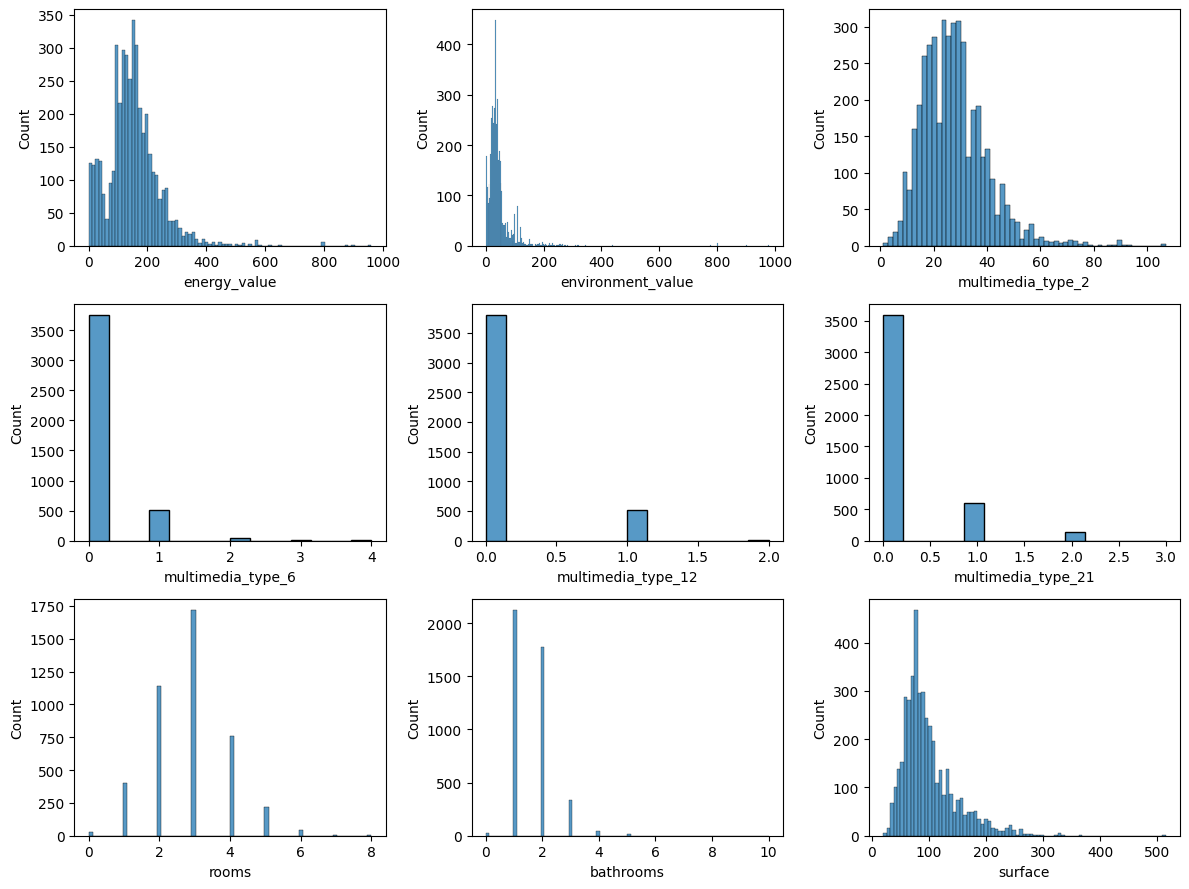

In [49]:
columns = ['energy_value', 'environment_value','multimedia_type_2', 'multimedia_type_6', 'multimedia_type_12',
           'multimedia_type_21', 'rooms', 'bathrooms', 'surface'] # 'multimedia_type_5'
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))
ax = ax.flatten()
for i, column in enumerate(columns):
    sns.histplot(df_num[column], ax=ax[i])
fig.tight_layout()
plt.show()

**lmplot** is a really good way to see how two numerical variables are correlated, depending on a descriptive variable. For example, surface and value are correlated, but not always with the same ratio. When we increase the surface, the value increases much faster in "Les Corts" than in "Nou Barris".

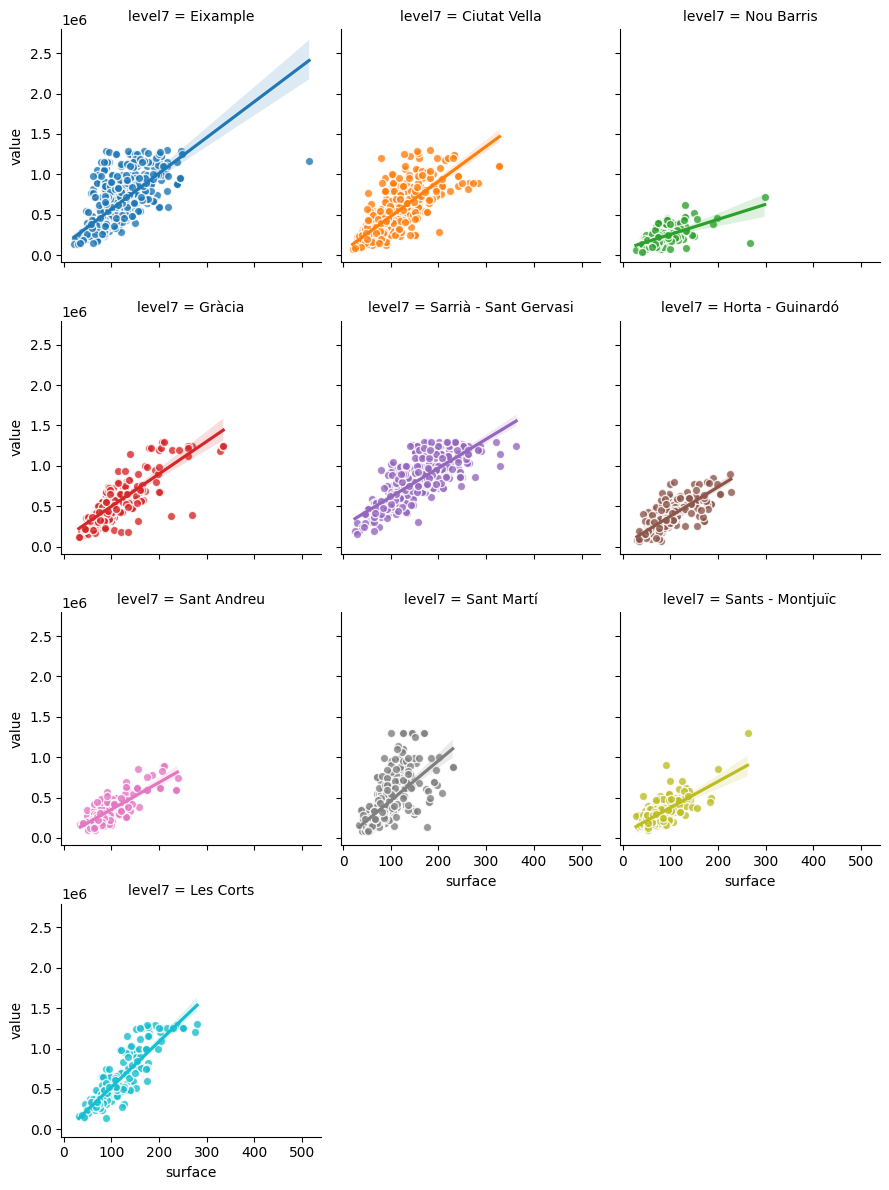

In [50]:
sns.lmplot(data=df_nonull, x="surface", y="value", col="level7", hue="level7",scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=3)
plt.show()

Number of bathrooms has a logical ascending pattern.

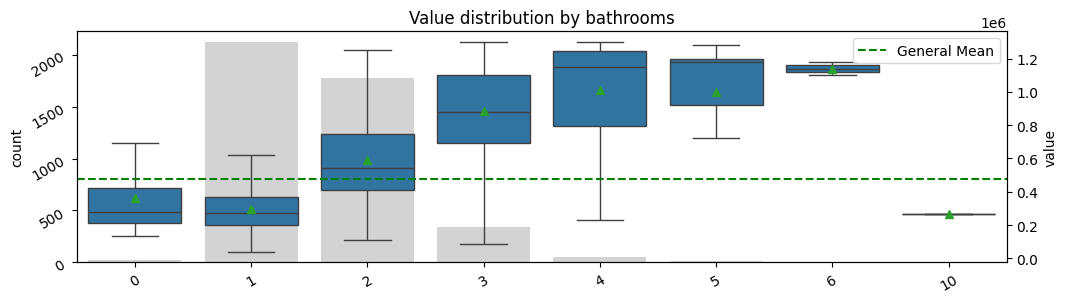

In [51]:
plot_boxplot_frequencies(["bathrooms"], ["bathrooms"], df_nonull)

The behavior of the value depending on the number of multimedia_type_2 (number of pictures) is really similar to the surface, as they are correlated features (as we can see in the correlation matrix), and it makes sense that the number of pictures is a consequence of the surface. The same happens with the number of bathrooms and rooms.

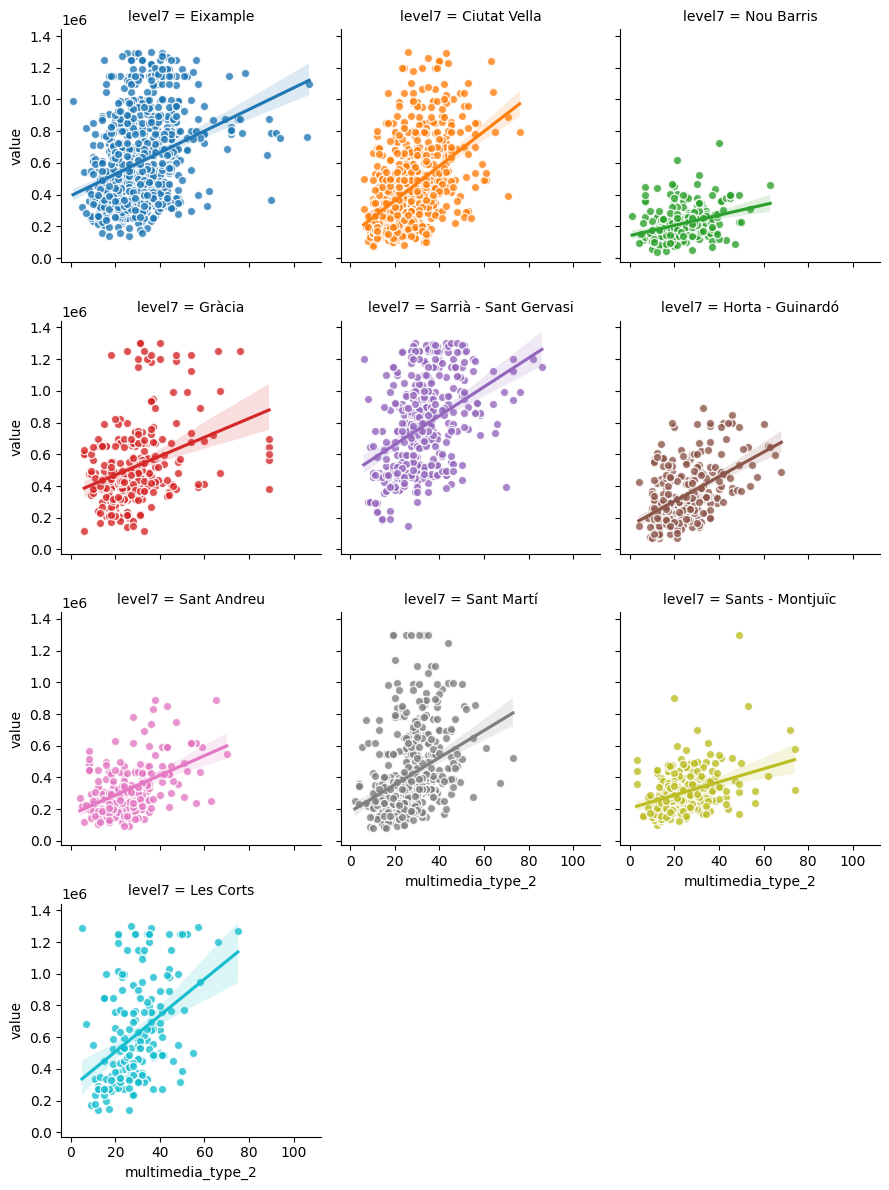

In [52]:
sns.lmplot(data=df_nonull, x="multimedia_type_2", y="value", col="level7", hue="level7",scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=3)
plt.show()

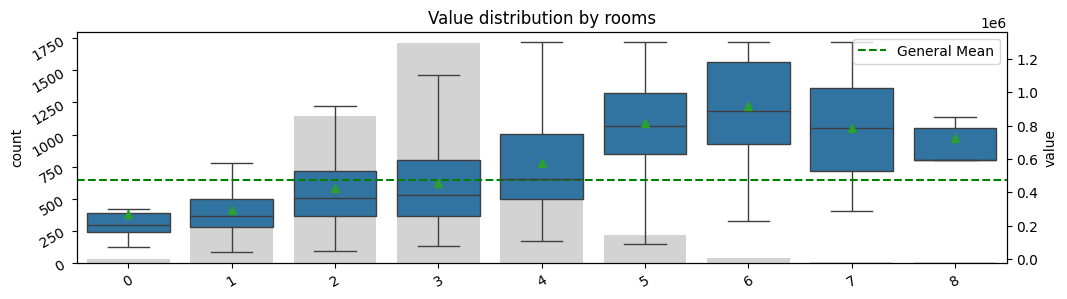

In [53]:
plot_boxplot_frequencies(["rooms"], ["rooms"], df_nonull)

## 3. Feature Engineering

The **Feature engineering part** is where we leverage everything learned previously to **create new features that can assist the model, modify them, and define which ones we will use and which ones we will not**.

We have tried different new variables, including:
- A more general version of 'floor_desc' ('floor_desc_grouped').
- The same 'floor_desc' replacing NaNs with 'NA'.
- Ordinal encoding in 'floor_desc' and creating an 'is_floor_num' column.
- Ordinal encoding of 'antiquity_desc'.

Finally, after observing their performance on the model, **we found that the features that gave the best results are the 'selected_features' ones**, **encoding the descriptive ones with one-hot encoding**. These features were selected based on our exploratory data analysis (EDA) and their performance in the model.

We also **remove special characters to avoid issues in column names once created by the get_dummies function**.

In [54]:
from unidecode import unidecode

def remove_accents(value):
    return unidecode(value) if isinstance(value, str) else value

def clean_values(data):
    data["level8"] = data["level8"].str.replace(r"[ '.,-]", "_", regex=True)
    data["floor_desc"] = data["floor_desc"].str.replace("ª","").str.replace(" ","")
    data[["level8"]] = data[["level8"]].applymap(remove_accents)
    data[["floor_desc"]] = data[["floor_desc"]].applymap(remove_accents)
    data[["antiquity_desc"]] = data[["antiquity_desc"]].applymap(remove_accents)
    data["antiquity_desc"] = data["antiquity_desc"].str.replace(r"anos|\s", "", regex=True)
    return data

df_feat = clean_values(df_nonull.copy())

In [55]:
df_feat = clean_values(df_nonull.copy())
df_feat["floor_desc_grouped"] = df_feat["floor_desc"].replace({"Subsótano":"Sótano", "Bajos":"Baj-Entre","Entresuelo":"Baj-Entre",
                                                        "10ª planta":">=10ª planta","11ª planta":">=10ª planta","12ª planta":">=10ª planta",
                                                        "13ª planta":">=10ª planta","14ª planta":">=10ª planta","15ª planta":">=10ª planta",
                                                        "A partir de la 15ª planta":">=10ª planta"})

df_feat["floor_desc_NA"] = df_feat["floor_desc"].fillna("NA")
df_feat["floor_desc_grouped_NA"] = df_feat["floor_desc_grouped"].fillna("NA")

df_feat["floor_ordinal_nans"] = np.where(df_feat["floor"]>0, df_feat["floor"], np.nan)
df_feat["is_floor_num"] = np.where(df_feat["floor"]>=6, True, False)



In [56]:
selected_features = ["rooms", "bathrooms", "surface","level8","energy_letter","environment_letter","energy_value","environment_value",
                         "floor_desc", "elevator","parking","Aire acondicionado","Parquet","Serv. portería","Balcón","Armarios","Calefacción",
                         "Suite - con baño","Terraza","Alarma","Cocina Equipada","Piscina","Gres Cerámica","Jardín Privado","Trastero"]

X = df_feat[selected_features]
y = df_feat["value"]

X_encoded = pd.get_dummies(X, columns=['level8','energy_letter','environment_letter','floor_desc'], drop_first=True)


## 4. Model

In [57]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV


### 4.1. Model Training

**After trying several regressors** (linear regressor, lightboost, random forest, catboost), the one that gave us a better approach is the **XGBRegressor**.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=76)

model = XGBRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on Test Set: {mse:.1f}')


Mean Absolute Error on Test Set: 74776.0


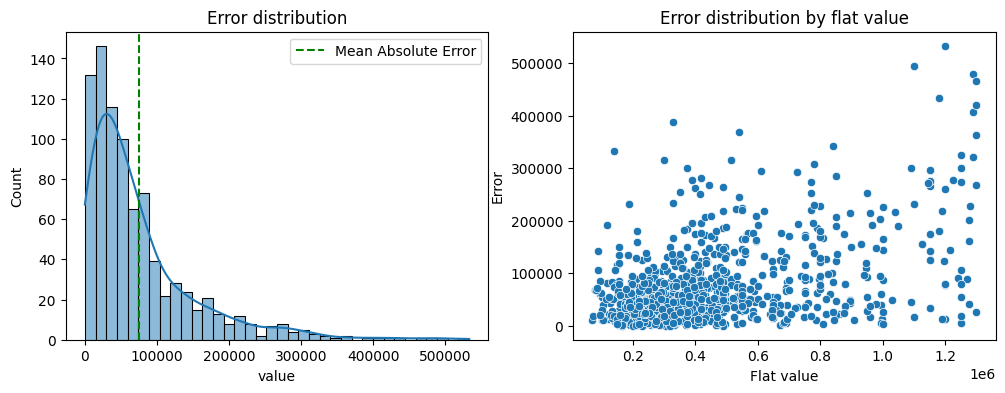

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.histplot(abs(y_pred-y_test), kde=True, ax=ax[0])
ax[0].axvline(x=np.mean(abs(y_test-y_pred)), color='g', linestyle='--', label='Mean Absolute Error')
ax[0].legend()
ax[0].set_title("Error distribution")

sns.scatterplot(x=y_test, y=abs(y_pred-y_test), ax=ax[1])
plt.xlabel("Flat value")
plt.ylabel("Error")
ax[1].set_title("Error distribution by flat value")

plt.show()

A **MAE of around 75000€ is a really good result considering that the value of a flat can reach more than 1M€**. With the mean value being around €475,000, the error percentage is about 16%. As we see on the "Error distribution by flat value", as the value of the flat increases, the margin of error can also increase significantly.

However, **we always need to conduct a Randomized/Grid search to determine if it can be further optimized and potentially achieve even better results.**

### 4.2. Model Optimization

In [82]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


In [83]:
model = XGBRegressor()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50,
                                   scoring='neg_mean_absolute_error', cv=5, verbose=1, random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Best Model's Mean Absolute Error on Test Set: {mae:.1f}")
best_params = random_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Model's Mean Absolute Error on Test Set: 70935.1
Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


**We have reduced the average error around 4.000€. Good news for our model!**


### 4.3. Model Evaluation

**In addition to the predictive power of a model for future use, we can extract conclusions from the model itself by identifying the feature importances.** This allows us to determine which features are most relevant for our target.

A comprehensive study can be conducted using SHAP values, but it requires high memory and time resources, making it impossible to run in my local environment.

In [84]:
feature_importances = best_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame
indices = np.argsort(feature_importances)[::-1]


In [85]:
df_features = pd.DataFrame({"feature_names":feature_names[indices],"feature_importances":feature_importances[indices]})

def extract_feature_group(feature_name):
    if feature_name.startswith('level8'):
        return 'level8'
    elif feature_name.startswith('floor_desc'):
        return 'floor_desc'
    elif feature_name.startswith('environment_l'):
        return 'environment'
    elif feature_name.startswith('energy_l'):
        return 'energy'
    else:
        return feature_name


df_features['feature_group'] = df_features['feature_names'].apply(extract_feature_group)
df_features_grouped = df_features[["feature_importances","feature_group"]].groupby("feature_group").mean().sort_values("feature_importances", ascending=False).reset_index()


As expected (thanks to our previous analysis), **the most relevant features are those generated by the neighborhood, surface area, bathrooms, elevator presence, air conditioning, and pool**.

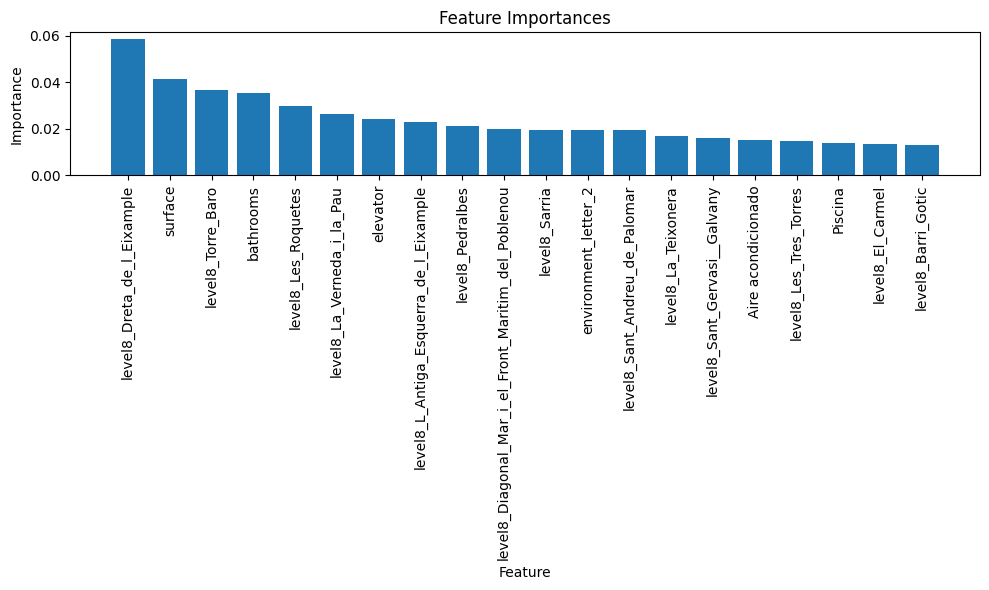

In [52]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(20), feature_importances[indices][:20], align="center")
plt.xticks(range(20), feature_names[indices][:20], rotation=90)  # Use feature names
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

To avoid overwhelming the model with too many individual geographical features, **I have grouped the features created with one-hot encoding into their respective categories.**

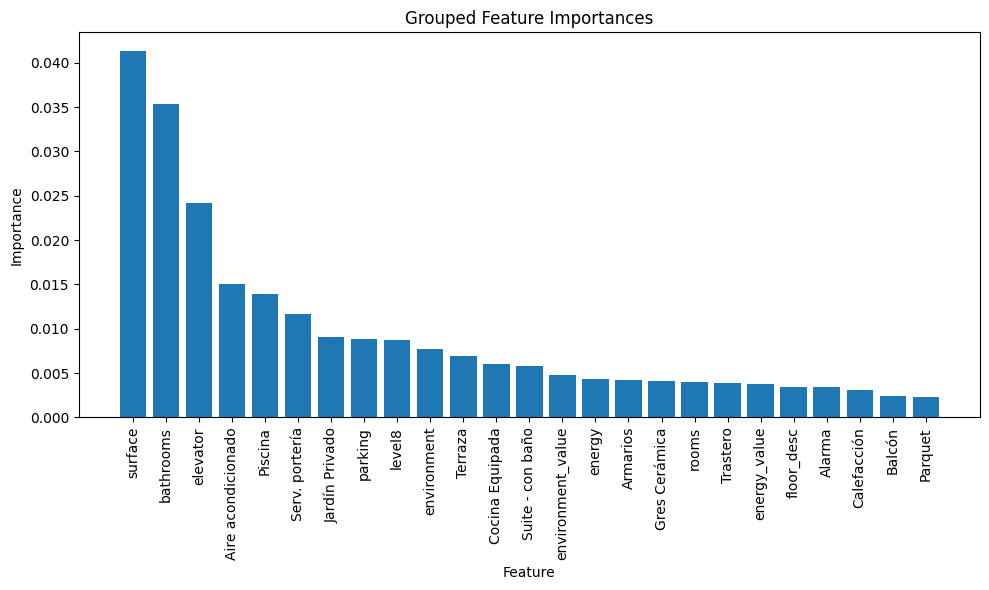

In [53]:
plt.figure(figsize=(10, 6))
plt.title("Grouped Feature Importances")
plt.bar(range(len(df_features_grouped.feature_importances)), df_features_grouped.feature_importances, align="center")
plt.xticks(range(len(df_features_grouped.feature_group)), df_features_grouped.feature_group, rotation=90)  # Use feature names
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

## 5. Conclusion

From my point of view, **the outcome of the project has been very satisfactory**. Typically, in educational projects and typical datasets, machine learning models end up performing very well, as the datasets are somehow already prepared to yield clear results and conclusions.

**In this case, the dataset is extracted using web scraping methods from a real estate comparison website, with data on real estate properties for sale in Barcelona in January 2024. That's why achieving these results holds significant value, as it is typically more challenging with real-world data.**

Essentially, we have created a model that, **given the characteristics of a property, predicts how much it should be sold for**, or at least the price at which similar properties are advertised. **This could be useful in the future to assist homeowners or real estate agencies in determining the value of their properties,** or for **people who are considering buying a property to validate if the price they are being offered is in line with what it should be.**

**Here we have a simple example of what we should do in the future with the input data of a new flat and the result that we will obtain. Obviously, if we want to put the model into production and call it from a web page, we will have to introduce the values through an interface, build the model into an API (program gets and sets), and monitor the model's performance in order to not have Data or Concept Drift, among other things.**

**But we will leave these options for the future :)**


In [162]:
X_test_real = pd.DataFrame(columns=X_test.columns)

# inputs
new_row = {"rooms":4, "bathrooms":2, "surface":95, "energy_value":100, "environment_value":100, "elevator":True, "parking":False,
          "Aire acondicionado":False, "Parquet":False, "Serv. portería":False, "Balcón":False, "Armarios":False, "Calefacción":False,
          "Suite - con baño":False, "Terraza":False, "Alarma":False, "Cocina Equipada":False, "Piscina":False, "Gres Cerámica":False,
           "Jardín Privado":False, "Trastero":False}

dummies_dict = {f"{col}":False for col in X_test.columns[21:]}

new_row.update(dummies_dict)

# inputs
neighbor = "level8_El_Camp_de_l_Arpa_del_Clot"
energy_letter = "energy_letter_4"
environment_letter = "environment_letter_3"
floor = "floor_desc_4planta"

new_row[neighbor] = True
new_row[energy_letter] = True
new_row[environment_letter] = True
new_row[floor] = True



In [163]:
for column in X_test.columns:
    X_test_real[column] = X_test_real[column].astype(X_test[column].dtype)

In [166]:
X_test_real = pd.concat([X_test_real, pd.DataFrame(new_row, index=[0])], ignore_index=True)
print("Predicted price:", best_model.predict(X_test_real)[0],"€")

Predicted price: 386982.1 €
